<a href="https://colab.research.google.com/github/MaggieHDez/MathStatsAI/blob/main/Generadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ran0: Generador Minimal Basado en LCG (Linear Congruential Generator)**

Este es el `Minimal random number generator` de Park y Miller.

Devuelve un número aleatorio uniforme entre 0.0 y 1.0. Para generar la secuencia se utiliza una semilla que se proporciona como una lista con un valor único entero (por ejemplo, `idum = [123456]`). Esto le permite al generador modificar el valor de la semilla internamente y se mantenga el estado entre las llamadas de la función.

rand0 emplea la siguiente configuración de constantes (idénticas a la versión en C):
  - IA = 16807 ($7^{5}$)
  - IM = 2147483647 ($2^{31} - 1$)
  - AM = $\frac{1.0}{IM}$ (para normalizar el resultado a un valor entre 0 y 1)
  - IQ = 127773
  - IR = 2836
  - MASK = 123459876
  
El procedimiento es el siguiente:
  1. Se enmascara la semilla usando una operación `XOR` con `MASK`, lo que permite el uso de 0 y otros
     patrones de bits simples.
  2. Se calcula el siguiente valor de la semilla mediante el método de Schrage, evitando desbordamientos.
  3. Si el valor de la semilla resulta negativo se corrige sumándole `IM`.
  4. Se normaliza el nuevo valor dividiéndolo entre `IM` para obtener un número flotante en `[0, 1)`.
  5. Finalmente, se desenmascara la semilla antes de retornar el valor aleatorio.

Para verificar la implementación de ran0, se generarán 10,000 números aleatorios y se visualiza un
histograma junto con la curva de densidad (`KDE`) utilizando `Seaborn`.

Si el histograma es plano y el
`KDE` es constante, se confirma que la distribución es uniforme.
A continuación se presenta la implementación en Python:

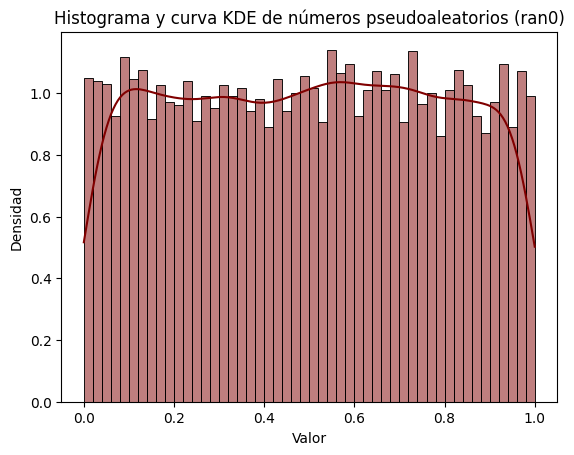

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def ran0(idum):

    # Definición de las constantes (como en C)
    IA = 16807               # 7**5
    IM = 2147483647          # 2**31 - 1
    AM = 1.0 / IM            # 1/IM
    IQ = 127773
    IR = 2836
    MASK = 123459876

    # Enmascarar la semilla
    idum[0] ^= MASK         # XOR de idum con MASK
    k = idum[0] // IQ       # División entera
    idum[0] = IA * (idum[0] - k * IQ) - IR * k  # Cálculo según el método de Schrage
    if idum[0] < 0:
        idum[0] += IM
    ans = AM * idum[0]      # Convertir a número flotante en [0, 1)
    idum[0] ^= MASK         # Desenmascarar la semilla antes de retornar
    return ans

# Prueba de ran0:
seed = [123456789]  # Definimos la semilla como una lista con un entero
num_values = 10000  # Número de valores a generar

random_numbers = [ran0(seed) for _ in range(num_values)]

# Histograma con curva KDE
sns.histplot(random_numbers, bins=50, stat='density', kde=True, color='maroon', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Histograma y curva KDE de números pseudoaleatorios (ran0)")
plt.show()

# **ran1: Generador aleatorio minimal de Park y Miller con barajeado Bays-Durham**

Este generador de números pseudoaleatorios utiliza el método `Minimal` de Park y Miller combinado con el barajeado (shuffle) de Bays-Durham (según la descripción de Knuth) para mejorar la calidad estadística de la secuencia.

El algoritmo devuelve un número uniforme en el intervalo (0, 1) y se inicializa pasando una semilla negativa a través de una lista mutable (por ejemplo, `idum = [-123456789]`). Una vez inicializado, **NO** se debe modificar `idum[0]` entre llamadas sucesivas, ya que el estado interno del generador se actualiza automáticamente.

Las constantes utilizadas se toman de Numerical Recipes:

  - IA   = 16807 ($7^{5}$)
  - IM   = 2147483647 ($2^{31} - 1$)
  - AM   = $\frac{1.0}{IM}$ (normalización)
  - IQ   = 127773
  - IR   = 2836
  - NTAB = 32 (tamaño de la tabla de barajeado)
  - NDIV = 1 + (IM - 1) // NTAB
  - EPS  = 1.2e-7
  - RNMX = 1.0 - EPS

Durante la inicialización, se llena una tabla (`iv`) mediante `NTAB + 7` iteraciones (`warm-ups`). Posteriormente,
en cada llamada, se actualiza la semilla usando el método de Schrage, se selecciona un valor de la tabla utilizando
un índice derivado y se actualiza la misma para obtener el nuevo número aleatorio, normalizado en `(0,1)` y evitando devolver el valor 1.

A continuación se presenta la implementación en Python:

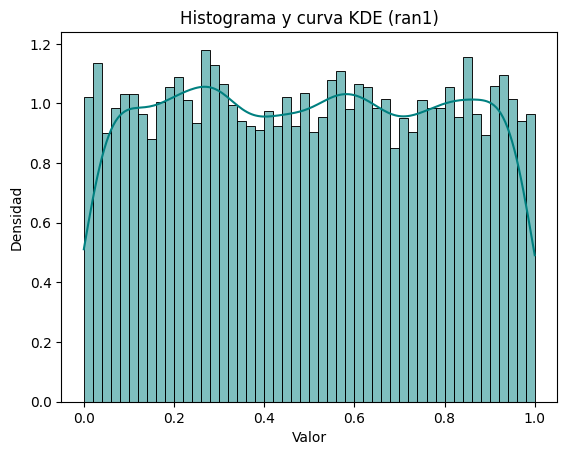

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def ran1(idum):

    # Constantes según Numerical Recipes
    IA   = 16807
    IM   = 2147483647
    AM   = 1.0 / IM
    IQ   = 127773
    IR   = 2836
    NTAB = 32
    NDIV = 1 + (IM - 1) // NTAB
    EPS  = 1.2e-7
    RNMX = 1.0 - EPS

    # Simular variables estáticas con atributos de la función
    if not hasattr(ran1, "iy"):
        ran1.iy = 0
    if not hasattr(ran1, "iv"):
        ran1.iv = [0] * NTAB

    # Inicialización: si idum[0] es <= 0 o si no se ha inicializado (iy==0)
    if idum[0] <= 0 or ran1.iy == 0:
        if -idum[0] < 1:
            idum[0] = 1
        else:
            idum[0] = -idum[0]

        # "Warm-up": llenar la tabla iv, repitiendo NTAB+7 veces
        for j in range(NTAB + 7, -1, -1):
            k = idum[0] // IQ
            idum[0] = IA * (idum[0] - k * IQ) - IR * k
            if idum[0] < 0:
                idum[0] += IM
            if j < NTAB:
                ran1.iv[j] = idum[0]
        ran1.iy = ran1.iv[0]

    # Generación de un nuevo número aleatorio
    k = idum[0] // IQ
    idum[0] = IA * (idum[0] - k * IQ) - IR * k
    if idum[0] < 0:
        idum[0] += IM
    j = ran1.iy // NDIV  # j estará en el rango 0..NTAB-1
    ran1.iy = ran1.iv[j]  # Se recupera el valor almacenado en el shuffle
    ran1.iv[j] = idum[0]  # Se reemplaza por el nuevo valor
    temp = AM * ran1.iy
    if temp > RNMX:
        return RNMX
    else:
        return temp

# Para mantener la semilla mutable.
seed = [-123456789]

# Prueba de ran1
num_values = 10000
random_numbers = [ran1(seed) for _ in range(num_values)]

# Histograma con curva KDE
sns.histplot(random_numbers, bins=50, stat='density', kde=True, color='teal', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Histograma y curva KDE (ran1)")
plt.show()


# **ran2: Generador pseudoaleatorio de L'Ecuyer con barajeado (shuffle) de Bays-Durham**

Este generador combina dos generadores lineales congruenciales con distintos parámetros utilizando el método de Schrage y el barajeado (`shuffle`) de Bays-Durham.

Genera números pseudoaleatorios uniformemente distribuidos en el intervalo `(0, 1)` (sin incluir el valor 1) y se inicializa pasando una semilla negativa a través de una lista mutable (por ejemplo, `idum = [-987654321]`).

Durante la inicialización se realiza un `warm-up` para llenar una tabla de barajeado de tamaño `NTAB` (32 elementos) usando las constantes definidas de Numerical Recipes.

Las principales constantes utilizadas son:

- IM1 = 2147483563
- IM2 = 2147483399
- AM = $\frac{1.0}{IM1}$
- IA1 = 40014
- IA2 = 40692
- IQ1 = 53668
- IQ2 = 52774
- IR1 = 12211
- IR2 = 3791
- NTAB = 32
- NDIV = 1 + (IM1 - 1) // NTAB
- EPS = 1.2e-7
- RNMX = 1.0 - EPS

El generador actualiza internamente la semilla (almacenada en `idum[0]`) y utiliza dos valores internos (uno en `idum2` y otro en la tabla `iv`) para mezclar la salida de ambos generadores, eliminando las correlaciones seriales. Una vez inicializado, **NO** se debe modificar la semilla entre llamadas.

A continuación se presenta la implementación en Python:

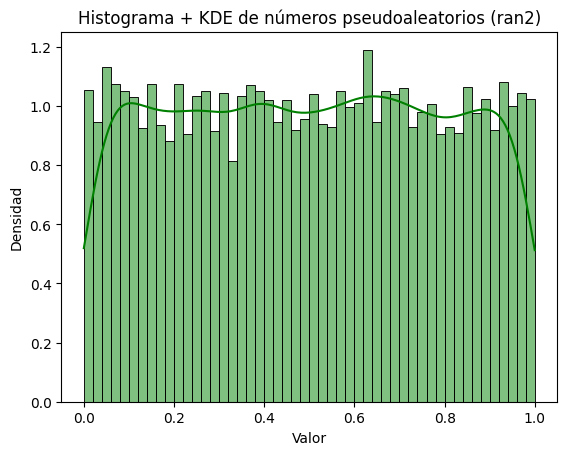

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def ran2(idum):

    # Constantes (según Numerical Recipes)
    IM1   = 2147483563
    IM2   = 2147483399
    AM    = 1.0 / IM1
    IMM1  = IM1 - 1
    IA1   = 40014
    IA2   = 40692
    IQ1   = 53668
    IQ2   = 52774
    IR1   = 12211
    IR2   = 3791
    NTAB  = 32
    NDIV  = 1 + (IMM1 // NTAB)
    EPS   = 1.2e-7
    RNMX  = 1.0 - EPS

    # Simulamos variables estáticas con atributos de la función
    if not hasattr(ran2, "idum2"):
        ran2.idum2 = 123456789
    if not hasattr(ran2, "iy"):
        ran2.iy = 0
    if not hasattr(ran2, "iv"):
        ran2.iv = [0] * NTAB

    # Inicialización: si idum[0] <= 0 se inicializa la tabla
    if idum[0] <= 0 or ran2.iy == 0:
        # Evitar que idum sea 0.
        if -idum[0] < 1:
            idum[0] = 1
        else:
            idum[0] = -idum[0]
        ran2.idum2 = idum[0]
        # "Warm-up": cargar la tabla de shuffle (NTAB + 7 iteraciones)
        for j in range(NTAB + 7, -1, -1):
            k = idum[0] // IQ1
            idum[0] = IA1 * (idum[0] - k * IQ1) - k * IR1
            if idum[0] < 0:
                idum[0] += IM1
            if j < NTAB:
                ran2.iv[j] = idum[0]
        ran2.iy = ran2.iv[0]

    # Generación de un nuevo número aleatorio
    k = idum[0] // IQ1
    idum[0] = IA1 * (idum[0] - k * IQ1) - k * IR1
    if idum[0] < 0:
        idum[0] += IM1

    k = ran2.idum2 // IQ2
    ran2.idum2 = IA2 * (ran2.idum2 - k * IQ2) - k * IR2
    if ran2.idum2 < 0:
        ran2.idum2 += IM2

    j = ran2.iy // NDIV  # j estará en el rango 0 ... NTAB-1
    ran2.iy = ran2.iv[j] - ran2.idum2  # Combina los generadores
    ran2.iv[j] = idum[0]
    if ran2.iy < 1:
        ran2.iy += IMM1

    temp = AM * ran2.iy
    if temp > RNMX:
        return RNMX
    else:
        return temp

# Usamos una lista para la semilla; para inicializar se pasa un valor negativo
seed = [-987654321]

num_values = 10000
values = [ran2(seed) for _ in range(num_values)]

# Visualización con Seaborn: Histograma con curva KDE
sns.histplot(values, bins=50, stat='density', kde=True, color='green', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Histograma + KDE de números pseudoaleatorios (ran2)")
plt.show()


# **ran3: Generador pseudoaleatorio sustractivo basado en el método de Knuth**

Genera números pseudoaleatorios basado en el método sustractivo propuesto por Knuth. Este algoritmo no utiliza el método lineal congruencial, sino que opera mediante una tabla interna de 56 números (utilizando los índices 1 a 55) y genera números aleatorios en el intervalo `(0, 1)` (sin incluir 1).

Para la inicialización se requiere pasar una semilla negativa a través de una lista mutable (por ejemplo, `seed = [-123456789]`); tras la inicialización, la semilla se reinicia a 1 para la generación, y el estado interno (almacenado en los atributos de la función: `inext`, `inextp`, `ma` y la variable de control `iff`) se actualiza en cada llamada.

Las constantes utilizadas se definen de la siguiente manera:

- MBIG = 1000000000
- MSEED = 161803398
- MZ = 0
- FAC = $\frac{1.0}{MBIG}$
- NTAB = 32
- IMM1 = MBIG - 1
- NDIV = 1 + (IMM1 // NTAB)
- EPS = 1.2e-7
- RNMX = 1.0 - EPS

Durante la inicialización se calcula un valor inicial (`mj`) basado en la diferencia entre `MSEED` y la semilla, y se llena la tabla `ma` en 54 posiciones en un orden pseudoaleatorio. Luego, mediante 4 pasadas de `calentamiento`, se mezclan los valores de la tabla para mejorar la aleatoriedad.

En cada llamada de `ran3` se incrementan los índices inext e inextp (con ajuste de envolvimiento), se calcula la diferencia de dos valores de la tabla, y se normaliza el resultado para obtener un número uniforme en `(0, 1)`, asegurando que el valor 1 no sea producido.

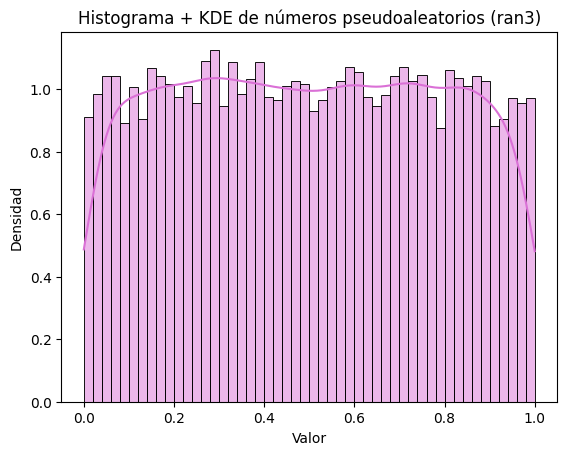

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def ran3(idum):

    # Constantes (según el código de Numerical Recipes)
    MBIG  = 1000000000
    MSEED = 161803398
    MZ    = 0
    FAC   = 1.0 / MBIG
    NTAB  = 32

    # NDIV se calcula en función de IMM1 = MBIG - 1
    IMM1  = MBIG - 1
    NDIV  = 1 + (IMM1 // NTAB)
    EPS   = 1.2e-7
    RNMX  = 1.0 - EPS

    # Inicialización: si idum[0] es negativo o si no se ha inicializado (la variable "iff" no existe)
    if idum[0] < 0 or not hasattr(ran3, "iff"):
        ran3.iff = True  # Marcamos que se ha inicializado

        # Creamos la lista "ma" con 56 elementos (índices 0 a 55); usaremos índices 1..55.
        ran3.ma = [0] * 56
        # Inicializamos las variables inext e inextp (deben ser estáticas)
        ran3.inext = 0
        ran3.inextp = 0

        # Inicialización: se calcula mj = labs(MSEED - labs(*idum)) mod MBIG
        mj = abs(MSEED - abs(idum[0]))
        mj %= MBIG
        # Se asigna a la posición 55 (índice 55) de ma
        ran3.ma[55] = mj
        mk = 1

        # Llena la tabla para i de 1 a 54 (en C: for (i=1;i<=54;i++))
        for i in range(1, 55):
            ii = (21 * i) % 55  # Nota: % devuelve un número entre 0 y 54
            ran3.ma[ii] = mk
            mk = mj - mk
            if mk < MZ:
                mk += MBIG
            mj = ran3.ma[ii]

        # “Calentamiento”: se mezclan (shuffle) los valores en la tabla en 4 pasadas
        for k in range(1, 5):
            for i in range(1, 56):
                j_index = 1 + ((i + 30) % 55)  # se obtiene un índice entre 1 y 55
                ran3.ma[i] = ran3.ma[i] - ran3.ma[j_index]
                if ran3.ma[i] < 0:
                    ran3.ma[i] += MBIG
        ran3.inext = 0
        ran3.inextp = 31  # Tal como se indica en el código en C
        idum[0] = 1     # Reinicializa la semilla para la generación

    # Parte de generación del número aleatorio:
    ran3.inext += 1
    if ran3.inext == 56:
        ran3.inext = 1
    ran3.inextp += 1
    if ran3.inextp == 56:
        ran3.inextp = 1
    mj = ran3.ma[ran3.inext] - ran3.ma[ran3.inextp]
    if mj < 0:
        mj += MBIG
    ran3.ma[ran3.inext] = mj
    temp = mj * FAC
    if temp > RNMX:
        return RNMX
    else:
        return temp

# Definición de semilla y valores.
seed = [-123456789]
num_values = 10000

# Prueba de ran3
values = [ran3(seed) for _ in range(num_values)]

# Histograma y la curva KDE con Seaborn
sns.histplot(values, bins=50, stat='density', kde=True, color='orchid', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Histograma + KDE de números pseudoaleatorios (ran3)")
plt.show()
